# Optical Flow Trajectory Prediction

## Imports and Utility

In [1]:
import os

import numpy as np
import numpy.linalg as npl
import pandas as pd
import scipy
import cv2 as cv
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
# import bokeh
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook

import torch

%matplotlib inline
#Import yolov5 for object detection/tracking
from yolov5 import YOLOv5
PROJECT_DEBUG = True
%matplotlib inline

#Switch to CUDA if we have a GPU we can use
yolo_pre_train_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

%matplotlib inline

# output_notebook()

Using cache found in /home/d1rtys0ck/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-4 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Loading BokehJS ...

In [2]:
#YOLO requires colors in images
def load_image_color(filepath: str) -> np.ndarray:
    im = cv.imread(filepath, cv.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(f"Image not found at {filepath}")
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im.astype(np.float32) / 255.0 

def load_image_gray(filepath: str) -> np.ndarray:
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {filepath}")
    mi = np.min(img)
    ma = np.max(img)
    return img / float(ma - mi)

def parse_meta(folder: str) -> Tuple[int, int, int, int]:
    supported_types = ['png', 'txt', 'jpg', 'jpeg']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    if 'meta.txt' not in supported_files:
        raise FileNotFoundError(f'meta.txt not found in {folder}')
    else:
        with open(os.path.join(folder, 'meta.txt'), 'r') as f:
            lines = f.readlines()
            if len(lines) < 4:
                raise Exception(f'Not enough lines in meta.txt')
            frame_width, frame_height, num_frames, frame_rate = (int(line) for line in lines[:4])

    return (frame_width, frame_height, num_frames, frame_rate)

def load_image_sequence(folder: str, color: bool = False) -> np.ndarray:
    supported_types = ['png', 'txt', 'jpg', 'jpeg']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]
    unsupported_files = [f for f in all_files if f not in supported_files]

    if PROJECT_DEBUG:
        if unsupported_files != []:
            print(f'Warning! Following files from {folder} are unsupported, ignoring: {", ".join(unsupported_files)}')

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

    if num_frames == 0:
        raise Exception(f'Folder must have at least one frame')
    if frame_width == 0 or frame_height == 0:
        raise Exception(f'Dimensions must result in non-zero number of pixels')

    image_files = [f for f in all_files if f.endswith('png') or f.endswith('jpg')]

    if len(image_files) < num_frames:
        raise FileNotFoundError(f'Not enough files for number of frames specified in meta.txt ({len(image_files)} < {num_frames})')

    if not color:
        video = np.zeros((num_frames, frame_height, frame_width))
    else:
        video = np.zeros((num_frames, frame_height, frame_width, 3), dtype=np.float32)

    load_function = load_image_color if color else load_image_gray

    if len(image_files) == 0:
        raise FileNotFoundError()

    for f_no, img_file in enumerate(image_files):
        video[f_no] = load_function(os.path.join(folder, img_file))

    if video is None:
        print("Failed to load")

    return video



## Derivatives

In [3]:
convolve = lambda img, flt: scipy.ndimage.convolve(img, flt, mode='nearest')

def horiz_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]],
        [[-2, 0, 2],
         [-4, 0, 4],
         [-2, 0, 2]],
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1],]
    ])

    return convolve(video, filt)

def vert_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
        [[-2, -4, -2],
         [0, 0, 0],
         [2, 4, 2]],
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

def time_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [-2, -4, -2],
         [-1, -2, -1]],
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
        [[1, 2, 1],
         [2, 4, 2],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

In [4]:
folder = './soccer/'
# folder = './blender_tests/throw1/mist/'

video = load_image_sequence(folder)
frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

I_x = horiz_deriv(video)
I_y = vert_deriv(video)
I_t = time_deriv(video)

for deriv in I_t:
    plt.figure()
    plt.imshow(deriv)

## Feature Detection

In [5]:
first_frame = video[0]
mask1 = np.zeros_like(first_frame)
mask1[:, 650:850] = 1
mask2 = np.zeros_like(first_frame)
mask2[100:200, :] = 1

mask = np.logical_and(mask1, mask2).astype(np.uint8)

track_points = cv.goodFeaturesToTrack(
    first_frame.astype('f4'),
    maxCorners=100,
    qualityLevel=0.1,
    minDistance=7,
    blockSize=7,
    mask=None)

plt.figure()
plt.imshow(first_frame, cmap='gray', vmin=-1, vmax=1)
plt.scatter(track_points[:, 0, 0], track_points[:, 0, 1], marker='.')


## Tracking

In [6]:
WINDOW_SIZE = 5

def get_window_coordinates(center: Tuple[int, int], win_size: int, lower_clamp=True) -> List[Tuple[int, int]]:
    xs = [x for x in range(center[0] - win_size // 2, center[0] + win_size // 2 + 1) if (not lower_clamp) or (x >= 0)]
    ys = [y for y in range(center[1] - win_size // 2, center[1] + win_size // 2 + 1) if (not lower_clamp) or (y >= 0)]

    coords = [(x, y) for x in xs for y in ys]
    return coords

frame1 = video[0]
frame2 = video[1]

u_field = np.zeros_like(frame1)
v_field = np.zeros_like(frame1)
zeroes = np.zeros_like(frame1)

l = 0.01

# while True:
for i in range(100):
    calculation = (I_x[0] * u_field + I_y[0] * v_field + I_t[0]) / ((1 / l) + I_x[0] ** 2 + I_y[0] ** 2)
    u_field -= calculation * I_x[0]
    v_field -= calculation * I_y[0]

x, y = np.meshgrid(np.arange(frame1.shape[0]), np.arange(frame1.shape[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


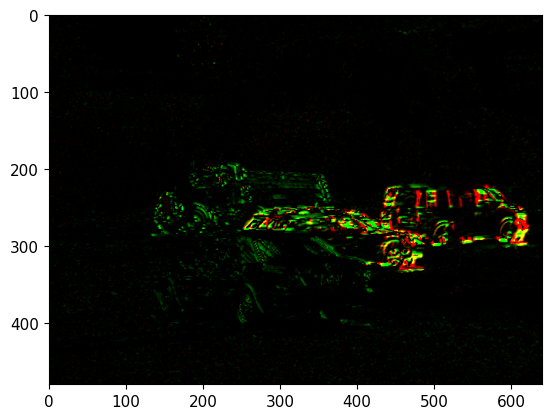

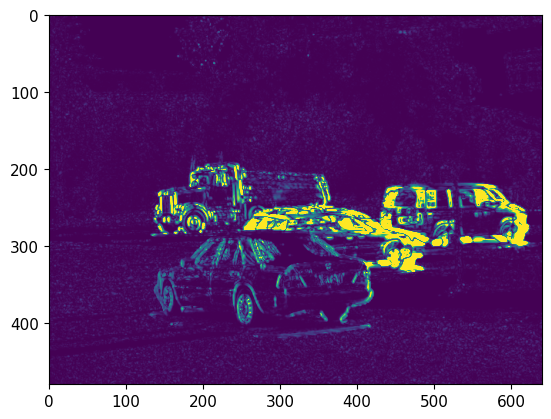

In [14]:
plt.figure()
plt.imshow(np.stack((u_field, v_field, zeroes), axis=2), vmin=-1, vmax=1)

plt.figure()
plt.imshow(
    np.sqrt((u_field ** 2) + (v_field ** 2)), vmin=0, vmax=1
     )